In [1]:
import requests
def get_usgs_gw1(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s-01-01&endDT=%s-12-31&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()
    #except:
        #return {"error": "Error on USGS access"}

# get daily groundwater value for stations in a state (1900-present) = this gets daily means
def get_usgs_gw2(state, start_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&siteStatus=active&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (start_year, where)
    try:
        req = requests.post(waterservices) 
        return req.json()
    except:
        return {"error": "Error on USGS access 2"}

In [2]:
# Date collection

def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
def num_of_reps(data, site):
    return len(data["value"]["timeSeries"][site]["values"][0]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    if values_len == 0:
        return 0
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        if float(get_gw_value(data, site, i)) > -100 and float(get_gw_value(data, site, i)) < 100:
            graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph


In [3]:
# Get monthly data at a station over a year
import numpy as np
import matplotlib.pyplot as plt
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

def gw_one_year(data, state, start_date, index_of_site, do_graph):
    new_data = {}
    if do_graph:
        print('data in %s' % (state))
        print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)
    for i in range(len(graph)):
        if list(graph.keys())[i][0:4] == start_date:
            new_data[list(graph.keys())[i]] = list(graph.values())[i]
    if new_data == 0:
        print("No data for this year at this station")
        return 0
    month_data = [0,0,0,0,0,0,0,0,0,0,0,0]
    month_data_2 = [0,0,0,0,0,0,0,0,0,0,0,0]
    # Organize data into months
    for i in range(len(new_data)):
        month_data[int(list(new_data.keys())[i][5:7]) - 1] += float(list(new_data.values())[i])
        month_data_2[int(list(new_data.keys())[i][5:7]) - 1] += 1
    for i in range(len(new_data)):
        month_data[int(list(new_data.keys())[i][5:7]) - 1] /= month_data_2[int(list(new_data.keys())[i][5:7]) - 1]
    if do_graph:
        plt.bar(MONTHS, month_data, color = "blue", width = 0.8)
        if len(list(new_data.values())) != 0:
            mean = sum(list(new_data.values())) / len(list(new_data.values()))
            print(f"Mean = {mean:.2f}")
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Groundwater in %s" % (start_date))
        plt.show()
    else:
        return [month_data]



In [4]:
# Get trend over years for the same month, same station

import numpy as np
import matplotlib.pyplot as plt


# MODIFY THESE
state = "NY"
start_date = "1980"
end_date = "2022"
month = "Apr"
index_of_site = 5

def gw_month_over_years(data, state, start_date, end_date, month, index_of_site, do_graph):
    MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]
    if do_graph:
        print('data in %s' % (state))
        print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)
    values = {}
    accumulator = []
    for y in range(int(end_date) - int(start_date)):
        accumulator.append(1)
        values[str(int(start_date) + y)] = 0
    for date in graph.keys():
        year = date[0:4]
        month2 = int(date[5:7])
        if month2 == (MONTHS.index(month) + 1):
            if year in values:
                values[year] += graph[date]
                accumulator[int(year) - int(start_date)] += 1
    for y in range(int(end_date) - int(start_date)):
        if str(y + int(start_date)) in values:
            values[str(y + int(start_date))] /= accumulator[y]

    #remove zeros for line of best fit
    lst = [range(int(end_date) - int(start_date)), list(values.values())]
    lst2 = []
    lst3 = []

    for j in range(int(end_date) - int(start_date)):
        if lst[1][j] != 0:
            lst2.append(lst[0][j])
            lst3.append(lst[1][j])
    x = np.array(lst2)
    y = np.array(lst3)
    #find line of best fit
    a, b = np.polyfit(x, y, 1)
    #add points to plot
    #add line of best fit to plot
    if do_graph:
        plt.plot(x, a*x+b)
        plt.bar(values.keys(), values.values(), color = "green", width = 0.8)
        plt.xlabel("Date")
        plt.ylabel("Value")
        plt.title("Groundwater in %s between %s and %s" % (month, start_date, end_date))
        plt.show()
        print(f"Slope of best fit: {a:.4f}")
    else:
        return [x, y, values.keys(), values.values()]

In [5]:
# Shows 12 month average of one year compared to average over decades
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

def compare_to_mean(data, state, selected_year, start_date, end_date, index_of_site, do_graph):
    # scatter plot points for every month over years
    # calculate average for every month over time frame
    # take input of monthy for that year (get_one_year)
    # scatter graph all the years, line draw the average and line draw the selected year
    '''ArithmeticErrorprint('data in %s' % (state))
    print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
    graph = show_site_data(data, index_of_site, False)'''
    full_data = []
    month_avg = []
    for months in range(12):
        accumulator = 0
        mean = 0
        mon_data = list(gw_month_over_years(data, state, start_date, end_date, (MONTHS[months]), index_of_site, False)[3])
        for value in mon_data:
            if value > 0:
                accumulator += 1
                mean += value
        if accumulator > 0:
            mean = mean / accumulator
        month_avg.append(mean)
        full_data.append(mon_data)
    # full data is [jan] [feb]
    #print(gw_one_year(data, state, start_date, index_of_site, False))
    #MEAN CALCULATED, PLOT MEAN
    #PLOT ALL YEARS JAN-DEC
    #PLOT TARGET YEAR
    plt.plot(MONTHS, month_avg, color = "green")
    for j in range((int(end_date) - int(start_date))):
        curr_data = []  
        for i in range(12):
            curr_data.append(full_data[i][j])
            if curr_data[-1] == 0:
                curr_data[-1] = None
        if int(selected_year) == (int(start_date) + j):
            plt.plot(MONTHS, curr_data, color = "red")
        else:
            plt.scatter(MONTHS, curr_data, color = "blue")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Groundwater in %s compared to average (%s to %s)" % (selected_year, start_date, end_date))
    plt.show()

In [6]:
# Avg every day
import datetime as dt

# REWRITE!
MON_ACCUM = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

def daily_analysis(graph, start, end, date, end_date, start2):
    '''numerical_form = {}
    # have dictionary of dates and values
    # make list of dates in numerical format
        # thousands place is year, 0 is start year.
    # turn specified date into number
    # for each year:
    # Calculate range for numbers
    # Do less than and greater than and search list
        # Accumulate and average, add to new dictionary
        # Apply to that year (year format)
    for i in graph:
        val = (int(i[0:4]) - int(start_date)) * 1000
        val += int(i[8:]) + MON_ACCUM[int(i[5:7]) - 1]
        numerical_form[val] = graph[i]
    date2 = int(date[3:]) + MON_ACCUM[int(date[0:2]) - 1]
    date_range = [0,0]
    if date2 + 7 > 365:
        date_range[1] = 1000 + date2 + 7 - 365
    else:
        date_range[1] = date2 + 7
    if date2 - 7 < 1:
        date_range[0] = -1000 - 365 + 7 - date2
    else:
        date_range[0] = date2 - 7
    new_items = {}
    for item in numerical_form:
        if int(str(item)[-3:]) > int(str((date_range)[0])[-3:]) and int(str(item)[-3:]) < int(str((date_range)[1])[-3:]):
            new_items[item] = numerical_form[item]
    #go through list, if they have the same year, average them to new dict, otherwise, add to new dict (year form)
    year_form = {}
    for year in range((int(end_date) - int(start_date))):
        accumulator = 0
        total = 0
        for item in new_items.keys():
            if item // 1000 == (year):
                accumulator += 1
                total += new_items[item]
        if accumulator > 0:
            total /= accumulator
        else:
            total = None
        key = int(start_date) + year
        year_form[str(key)] = total
    print(year_form)
    plt.scatter(list(year_form.keys()), list(year_form.values()), color = "blue")
    if len(list(year_form.values())) != 0:
        accumulator = 0
        mean = 0
        for i in list(year_form.values()):
            if i != None:
                mean += i
                accumulator += 1
        mean /= accumulator
        print(f"Mean = {mean:.2f}")
        plt.axhline(mean)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title("Groundwater for days (2 week average around %s)" % (date))
    plt.show()'''
    date_data = []
    for date in list(graph.keys()):
        #print(str(graph(date)))
        date_data.append([dt.datetime(int(date[0:4]),int(date[5:7]),int(date[8:10])), graph[date]])
    total_data = []
    while start.year < int(end_date):
        lst = []
        accum = 0
        for i in date_data:
            if i[0] >= start and i[0] <= end:
                lst.append(i)
                accum += i[1]
        if len(lst):
            total_data.append([start2.year, accum / len(lst)])
        #if start.year % 4 == 0 and start.month == 2:
            # LEAP YEAR
        start = dt.datetime(start.year + 1, start.month, start.day)
        start2 = dt.datetime(start2.year + 1, start2.month, start2.day)
        end = dt.datetime(end.year + 1, end.month, end.day)
    return total_data



In [76]:
# graph change in gw levels for one station, sorted from decrease to increase
import matplotlib.pyplot as plt
import numpy as np
MONTH_DATA = [31,28,31,30,31,30,31,31,30,31,30,31,31]

def sortkey(e):
    return e[1]

def graph_comparison(data, date, start_date, end_date, index_of_site, window, plotting, percentile):
    graph = show_site_data(data, index_of_site, False)
    if len(date) == 5:
        date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
        start = date + dt.timedelta(weeks=-1 * window)
        end = date + dt.timedelta(weeks=window,days=-1)
        start2 = date + dt.timedelta(weeks=window)
        end2 = date + dt.timedelta(weeks=3 * window,days=-1)
    else:
        start = dt.datetime(int(start_date), int(date), 1)
        end = dt.datetime(int(start_date), int(date), int(MONTH_DATA[int(date) - 1]))
        start2 = end + dt.timedelta(days=1)
        end2 = end + dt.timedelta(days= MONTH_DATA[int(date)] + 1)
    if plotting:
        print(f'Range of data set 1: {start} - {end}\nRange of data set 2: {start2} - {end2}')
    first_set = daily_analysis(graph, start, end, date, end_date, start)
    second_set = daily_analysis(graph, start2, end2, date, end_date, start)
    plottable = []
    for i in first_set:
        for j in second_set:
             if j[0] == i[0]:
                  plottable.append([i[0], j[1] - i[1]])
    #for i in range(len(first_set)):
            #plottable.append([first_set[i][0], second_set[i][1] - first_set[i][1]])
    plottable.sort(key=sortkey)
    dct = {}
    for i in plottable:
        dct[(str(i[0]))[2:4]] = i[1]
    if plotting:
        plt.bar(dct.keys(), dct.values(), color = "green", width = 0.8)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.title("Groundwater (%s) versus period after" % (date))
        plt.show()
    else:
        if len(dct) > 0:
            if percentile != 0:
                a = list(dct.values())
                a = np.array(a)
                p = np.percentile(a, percentile)  # return 50th percentile, i.e. median.
                return p
            else:
                # [mean, median, interquartile range,standard deviation]
                a = list(dct.values())
                a = np.array(a)
                return [list(dct.values()), np.mean(a), np.median(a), np.percentile(a, 75) - np.percentile(a, 25), np.std(a)]
    

In [80]:
# percentiles!
NY_STATIONS = [569, 527, 509, 472, 487, 548, 526, 587, 490, 466, 489, 561, 486, 327, 422, 39, 18, 578]
VT_STATIONS = [13, 14]
MA_STATIONS = [90, 165, 163, 119, 150, 144]
ME_STATIONS = [2]
CT_STATIONS = [71, 48, 11, 32, 49, 33, 35, 42, 62, 34]
RI_STATIONS = [3, 5, 4]
def percent(data, date, start_date, end_date, percentile, state, station):
    match state:
        case "NY":
            lookat = NY_STATIONS
        case "VT":
            lookat = VT_STATIONS
        case "MA":
            lookat = MA_STATIONS
        case "ME":
            lookat = ME_STATIONS
        case "CT":
            lookat = CT_STATIONS
        case "RI":
            lookat = RI_STATIONS
    all_stations = []
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    if station == "all":
        for item in lookat:
            one_station = []
            # DO FOR EVERY WEEK OF THE YEAR
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                one_station.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, item, 0.5, False, percentile[0]))
            all_stations.append(one_station)
        for i in all_stations:
            plt.plot(range(52), i, color = (0,0, 1,1))
        plt.title("GW: %s percentile across %s stations" % (percentile[0], state))
    else:
        for i in percentile:
            all_stations = []
            for week in range(52):
                date2 = date + dt.timedelta(days= 7 * week)
                #Convert to string
                mo = str(date2.month)
                da = str(date2.day)
                if len(mo) == 1:
                    mo = "0" + mo
                if len(da) == 1:
                    da = '0' + da
                all_stations.append(graph_comparison(data, f"{mo}-{da}", start_date, end_date, int(station), 0.5, False, i))
            plt.plot(range(52), all_stations, color = (i * 0.02,0,1 - i * 0.02,1))
        plt.title("GW: %sth percentile in station %s (%s)" % (percentile, station, get_site(data, int(station))))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    return all_stations
    #print(all_stations)


In [94]:
# SHOW DIFFERENT WAYS TO CALCULATE DIFFERENCES (Utils graph_comparison(), not percent())
def differences(data, date, start_date, end_date, index_of_site, window):
    PERCENTILES = [5, 10, 25, 33]
    date = dt.datetime(int(start_date), int(date[0:2]), int(date[3:5]))
    perm_diff1 = []
    perm_diff2 = []
    perm_diff3 = []
    perm_diff4 = []
    for week in range(52):
        date2 = date + dt.timedelta(days= 7 * week)
        #Convert to string
        mo = str(date2.month)
        da = str(date2.day)
        if len(mo) == 1:
            mo = "0" + mo
        if len(da) == 1:
            da = '0' + da
        stats = (graph_comparison(data, f"{mo}-{da}", start_date, end_date, index_of_site, window, False, 0))
        diff1 = []
        diff2 = []
        diff3 = []
        diff4 = []
    # [data, mean, median, interquartile range,standard deviation]
        for value in stats[0]:
            diff1.append(value - stats[1])
            diff2.append(value - stats[2])
            diff3.append((value - stats[1])/stats[4])
            diff4.append((value - stats[2])/stats[3])
        # turn into percentiles and put into perm list for each week
        a = list(diff1)
        a = np.array(a)
        b = list(diff2)
        b = np.array(b)
        c = list(diff3)
        c = np.array(c)
        d = list(diff4)
        d = np.array(d)
        perm_diff1.append([np.percentile(a, PERCENTILES[0]),np.percentile(a, PERCENTILES[1]),np.percentile(a, PERCENTILES[2]),np.percentile(a, PERCENTILES[3])])
        perm_diff2.append([np.percentile(b, PERCENTILES[0]),np.percentile(b, PERCENTILES[1]),np.percentile(b, PERCENTILES[2]),np.percentile(b, PERCENTILES[3])])
        perm_diff3.append([np.percentile(c, PERCENTILES[0]),np.percentile(c, PERCENTILES[1]),np.percentile(c, PERCENTILES[2]),np.percentile(c, PERCENTILES[3])])
        perm_diff4.append([np.percentile(d, PERCENTILES[0]),np.percentile(d, PERCENTILES[1]),np.percentile(d, PERCENTILES[2]),np.percentile(d, PERCENTILES[3])])
    for i in range(len(perm_diff1[0])):
        temp = []
        for j in perm_diff1:
            temp.append(j[i])
        plt.plot(range(52), temp, color = "green")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 1 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff2[0])):
        temp = []
        for j in perm_diff2:
            temp.append(j[i])
        plt.plot(range(52), temp, color = "green")
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.title("GW: difference calculcation 2 for station %s" % (get_site(data, index_of_site)))
    plt.show()
    for i in range(len(perm_diff3[0])):
        temp = []
        for j in perm_diff3:
            temp.append(j[i])
        plt.plot(range(52), temp, color = "green")
    plt.title("GW: difference calculcation 3 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
    for i in range(len(perm_diff4[0])):
        temp = []
        for j in perm_diff4:
            temp.append(j[i])
        plt.plot(range(52), temp, color = "green")
    plt.title("GW: difference calculcation 4 for station %s" % (get_site(data, index_of_site)))
    plt.xlabel("Week")
    plt.ylabel("Value")
    plt.show()
        

        # need list of 52 percentile values for diff1
        # need list of 52 percentile values for diff2

    


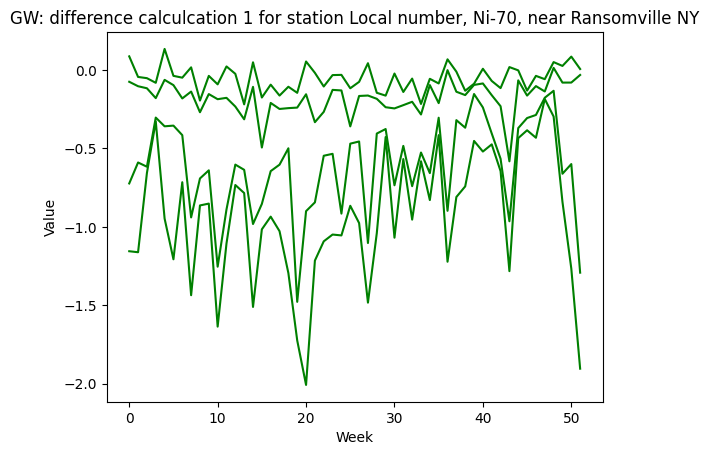

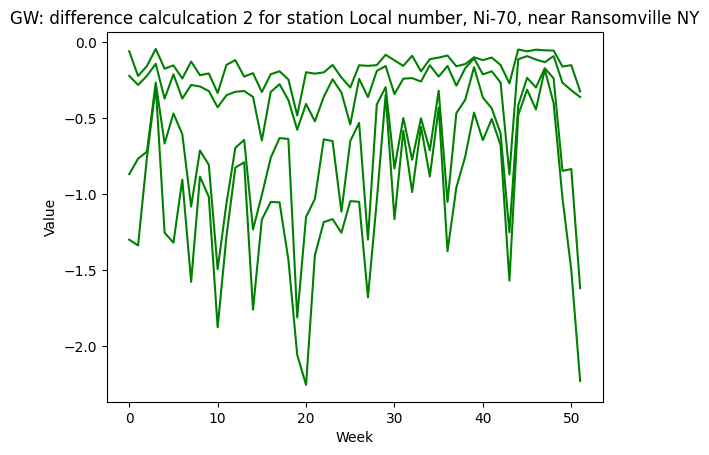

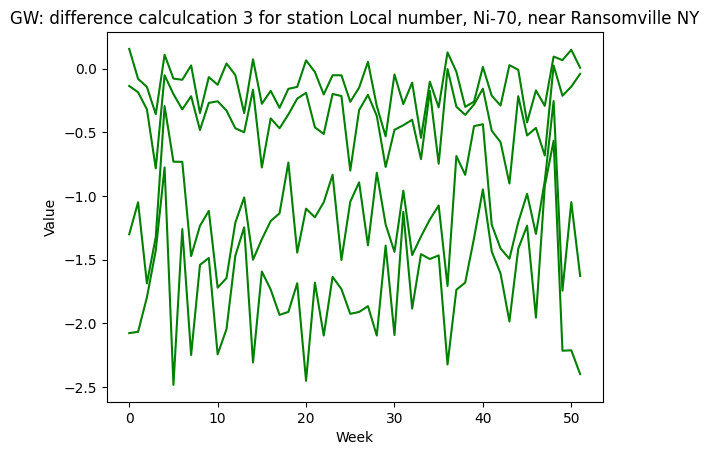

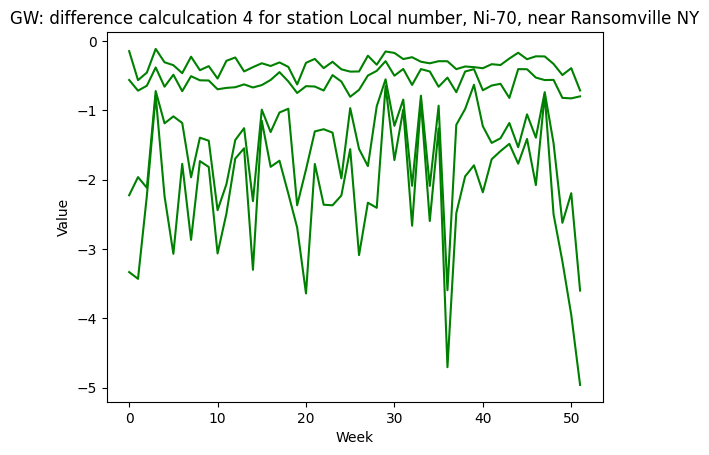

In [95]:
'''
datetime utils
stats
graph of for each year, average distance between each recording (weeks/months etc) for each station
gather percentiles for top ___ stations
    5%, 10%, etc
        period of record for each station
        return of percentile and value
print out median (50%tile)
see how percentiles vary throughout the year
'''
import statistics as stats
state = "NY"
start_date = "1900"
end_date = "2023"
year = "2000"
date = "10-05"
window_in_wks = 0.5
percentile = [5]

data = get_usgs_gw1(state, start_date, end_date)
#compare_to_mean(data, state, "2020", start_date, end_date, 13, True)
#gw_month_over_years(data, state, start_date, end_date, "Apr", 13, True)
#gw_one_year(data, state, year, 13, True)
differences(data, date, start_date, end_date, 569, window_in_wks)
#graph_comparison(data, date, start_date, end_date, 569, window_in_wks, True, percentile)
#percent(data, "01-05", start_date, end_date, percentile, state, "all")
#percentile = [5,10,25,33]
#a = percent(data, "01-05", start_date, end_date, percentile, state, "569")
#for i in range(52):
    #print(f'{percentile}%: Week {i + 1}: {a[i]:.2f}')



In [10]:
# Gather Site Data
import datetime as dt

'''
find sites with most data
    weekly
    daily
look at value length
need 30+ years of data too

datetime import (learn that!)
'''
def sortkey(e):
    return e[-2]

state = "NY"
start_date = "1900"
end_date = "2023"
stations = []
data = get_usgs_gw1(state, start_date, end_date)
for i in range(len(data["value"]["timeSeries"])):
    reps = num_of_reps(data, i)
    if reps > 999:
        differences = []
        for num in range(reps):
            if num + 1 < reps:
                value1 = get_gw_date(data, i, num)
                value2 = get_gw_date(data, i, num + 1)
                value3 = dt.datetime(int(value1[0:4]), int(value1[5:7]), int(value1[8:10]))
                value4 = dt.datetime(int(value2[0:4]), int(value2[5:7]), int(value2[8:10]))
                differences.append([value1, (value4 - value3).days])
        # calculate average duration between each input
        #print(differences)
        curr_category = ''
        category = ''
        temp_list = []
        category_lst = []
        start_d = ''
        for val in differences:
            if val[1] > 0 and val[1] < 4:
                category = 'daily'
            elif val[1] > 5 and val[1] < 10:
                category = 'weekly'
            elif val[1] > 25 and val[1] < 35:
                category = 'monthly'
            else:
                category = ''
            if curr_category == '':
                curr_category = category
                start_d = val[0]
            if category != curr_category:
                temp_list.append(category)
                if len(temp_list) == 3:
                    category_lst.append([start_d, val[0], curr_category])
                    curr_category = category
                    start_d = val[0]
                    temp_list = []
        #print(category_lst)
        dailys = 0
        weeklys = 0
        monthlys = 0
        for j in category_lst:
            if j[2] == "daily":
                dailys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
            if j[2] == "weekly":
                weeklys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
            if j[2] == "monthly":
                monthlys += (dt.datetime(int(j[1][0:4]), int(j[1][5:7]), int(j[1][8:10])) - dt.datetime(int(j[0][0:4]), int(j[0][5:7]), int(j[0][8:10]))).days
        station = get_site(data, i)
        stations.append([i, station ,f'{reps} total entries', get_gw_date(data, i, 0), f"daily for {dailys} total days ({dailys / 365:.1f} years), weekly across {weeklys/7:.1f} weeks ({weeklys/7/52:.1f} years), monthly across approx. {monthlys/30.43:.1f} months"])
        '''
        Check in 3 different categories:
        1-3 days (daily)
        5-10 days (weekly)
        25-35 days (monthly)

        if date falls into category, set curr_category to that
        if date doesnt fall into category, add to temp list
        if temp list reaches 3 long, set new category to what the temp list values are, keep going
        every time category changes, append start and end date of category to list
        if dates dont fall into category, skip over
        '''
    #print(f'({i} {get_site(data, i)} ----> {num_of_reps(data, i)}')
stations.sort(reverse = True, key=sortkey)
nums = []
for i in stations:
    #print(i)
    print(f'{i[0]}    {i[1]}\n\t   {i[2]}, first entry: ({i[3]})\n\t\t{i[4]}\n')
    nums.append(i[0])
print(nums)


569    Local number, Ni-70, near Ransomville NY
	   1458 total entries, first entry: (1972-08-05)
		daily for 793 total days (2.2 years), weekly across 1169.3 weeks (22.5 years), monthly across approx. 44.6 months

527    Local number, Cy-7, near Moravia NY
	   1197 total entries, first entry: (1965-11-30)
		daily for 445 total days (1.2 years), weekly across 1122.6 weeks (21.6 years), monthly across approx. 74.5 months

509    Local number, Sb-472, near Kanona NY
	   1674 total entries, first entry: (1965-11-19)
		daily for 1134 total days (3.1 years), weekly across 1402.7 weeks (27.0 years), monthly across approx. 64.1 months

472    Local number, Du-1009, ST Park, Pleasant Valley NY
	   1015 total entries, first entry: (1965-10-22)
		daily for 201 total days (0.6 years), weekly across 807.7 weeks (15.5 years), monthly across approx. 54.8 months

487    Local number, U-1619, Tillson NY
	   1348 total entries, first entry: (1964-10-15)
		daily for 1172 total days (3.2 years), weekly a